# Exercise 30 Solution - Diffusion models

### Task
Train a diffusion model for data generation using a fiber microstructure dataset

### Learning goals
- Understand how a diffusion model works (including the noising and denoising process)
- Familiarize yourself with the implementation of a diffusion model

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)

## Hyperparameters

**data generation parameters**

In [3]:
N = 64
domainLength = 1
numberOfCircles = 5
radius = 0.12
min_max_side_length = (0.8, 0.8)

numberOfSamples = 1280  #12800

**training parameters**

In [4]:
batch_size = 128
n_epochs = 20
lr = 1e-3

 ## Data generation

**helper functions to generate dataset**

In [5]:
def generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius):
    domain = np.ones((N, N))
    x = np.linspace(0, domainLength, N)
    y = np.linspace(0, domainLength, N)
    x, y = np.meshgrid(x, y)

    for i in range(numberOfCircles):
        overlap = True
        while overlap == True:
            xc = np.random.uniform(radius, domainLength - radius)
            yc = np.random.uniform(radius, domainLength - radius)

            mask = (x - xc) ** 2 + (y - yc) ** 2 < radius ** 2
            if ~np.any(domain[mask] == 0):
                overlap = False
        domain[mask] = 0
    return domain

**data generation**

In [6]:
samples = torch.zeros((numberOfSamples, 1, N, N))
for i in range(numberOfSamples):
    samples[i, 0] = torch.from_numpy(
        generateNonOverlappingCirclesInDomain(N, domainLength, numberOfCircles, radius)).to(torch.float32)
torch.save(samples, f"data/normalData{N}.pt")

**visualize the first 5 generated microstructures**

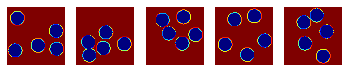

In [7]:
fig, axes = plt.subplots(1, 5)
for i, ax in enumerate(axes):
    sample = samples[i].squeeze()
    ax.imshow(sample, cmap='jet')
    ax.axis('off')
plt.show()


## Dataset definition

**load generated data into PyTorch dataset**

In [8]:
class microstructureDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)

        if self.labels is None:
            return sample, 0
        else:
            label = self.labels[idx]
            return sample, label

**dataset instantiation**

In [9]:
data = torch.load('data/normalData64.pt', weights_only=False)
#labels = torch.load('data/shapeLabels64.pt', weights_only=False) # TODO ask moritz?
dataset = microstructureDataset(data[1:12800])
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

**visualize part of the dataset**

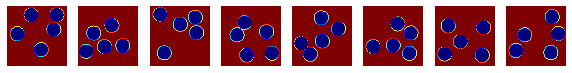

In [10]:
x, y = next(iter(train_dataloader))  # TODO ask Moritz what y is?

fig, axes = plt.subplots(1, 8, figsize=(10, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(x[i][0].cpu(), cmap='jet')
    ax.axis('off')
plt.show()

## Data corruption through noise

**helper function defining the noising process**

In [11]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount


**visualization of the noising process**

noising amount: tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])
labels: ['0', '1', '2', '3', '4', '5', '6', 'T']


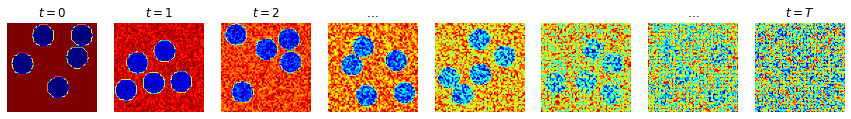

In [12]:
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)
print("noising amount: " + str(amount.data))

t_labels = [f'{i}' for i in range(7)]
t_labels.append('T')
print("labels: " + str(t_labels))

fig, axes = plt.subplots(1, 8, figsize=(15, 3))
for i in range(8):
    axes[i].imshow(noised_x[i][0], cmap='jet')
    axes[i].axis('off')

axes[0].set_title(r'$t = 0$')
axes[1].set_title(r'$t = 1$')
axes[2].set_title(r'$t = 2$')
axes[3].set_title(r'$\dots$')
axes[6].set_title(r'$\dots$')
axes[7].set_title(r'$t = T$')

plt.show()

As the noise amount approaches one, our data begins to look like pure random noise. But for most noise amounts, you can guess the fiberd distribution fairly well. Do you think this is optimal?

## Neural network architecture definition

In [13]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

## Training

**data preparation**

In [14]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

**neural network instantiation**

In [15]:
net = BasicUNet()
net.to(device)
random_noise = torch.rand(8, 1, N, N)
print("number of parameters: " + str(sum([p.numel() for p in net.parameters()])))

number of parameters: 309057


**loss function, optimizer and history**

In [16]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=lr)

losses = []

**training loop**

In [17]:
for epoch in range(n_epochs):

    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.294248
Finished epoch 1. Average loss for this epoch: 0.117224
Finished epoch 2. Average loss for this epoch: 0.093269
Finished epoch 3. Average loss for this epoch: 0.076892
Finished epoch 4. Average loss for this epoch: 0.065278
Finished epoch 5. Average loss for this epoch: 0.056161
Finished epoch 6. Average loss for this epoch: 0.053052
Finished epoch 7. Average loss for this epoch: 0.046337
Finished epoch 8. Average loss for this epoch: 0.041037
Finished epoch 9. Average loss for this epoch: 0.041129
Finished epoch 10. Average loss for this epoch: 0.039335
Finished epoch 11. Average loss for this epoch: 0.038699
Finished epoch 12. Average loss for this epoch: 0.038790
Finished epoch 13. Average loss for this epoch: 0.035684
Finished epoch 14. Average loss for this epoch: 0.033851
Finished epoch 15. Average loss for this epoch: 0.034356
Finished epoch 16. Average loss for this epoch: 0.033135
Finished epoch 17. Average loss for this 

## Post-processing

**cost history**

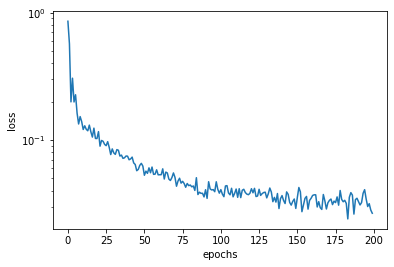

In [18]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_yscale('log')
plt.show()

**visualization of model predictions from the corrupted data**

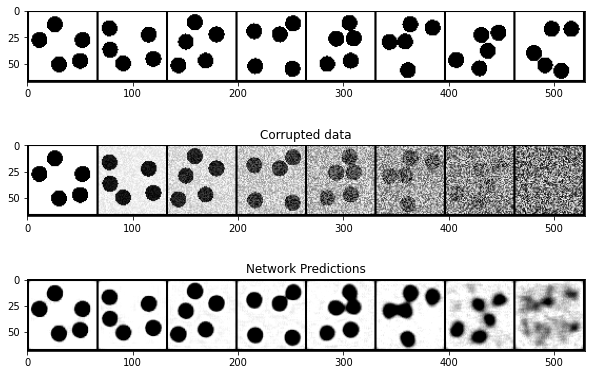

In [19]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='gray')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='gray')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='gray')
plt.show()

**Visualization of noising process (through corruption) and denoising process (through neural network)**

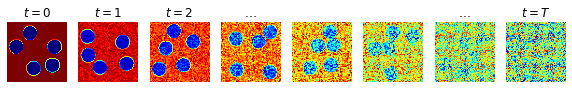

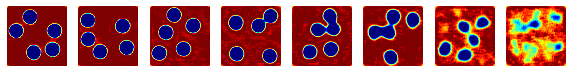

In [21]:
fig, axes = plt.subplots(1, 8, figsize=(10, 2))

for i in range(8):
    axes[i].imshow(noised_x[i][0], cmap='jet')
    axes[i].axis('off')

axes[0].set_title(r'$t = 0$')
axes[1].set_title(r'$t = 1$')
axes[2].set_title(r'$t = 2$')
axes[3].set_title(r'$\dots$')
axes[6].set_title(r'$\dots$')
axes[7].set_title(r'$t = T$')

plt.show()

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

fig, axes = plt.subplots(1, 8, figsize=(10, 2))

for i in range(8):
    axes[i].imshow(preds[i][0], cmap='jet', vmin=0, vmax=1)
    axes[i].axis('off')

plt.show()

**Visualization of the mapping**

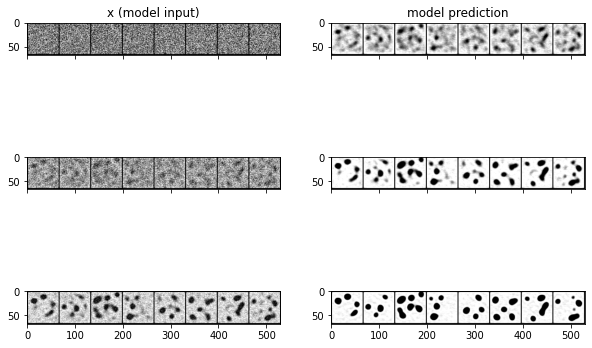

In [22]:
n_steps = 3
x = torch.rand(8, 1, N, N).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(10, 7), sharex=True)
axs[0, 0].set_title('x (model input)')
axs[0, 1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='gray')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='gray')
plt.show()

**generation of 64 new samples**

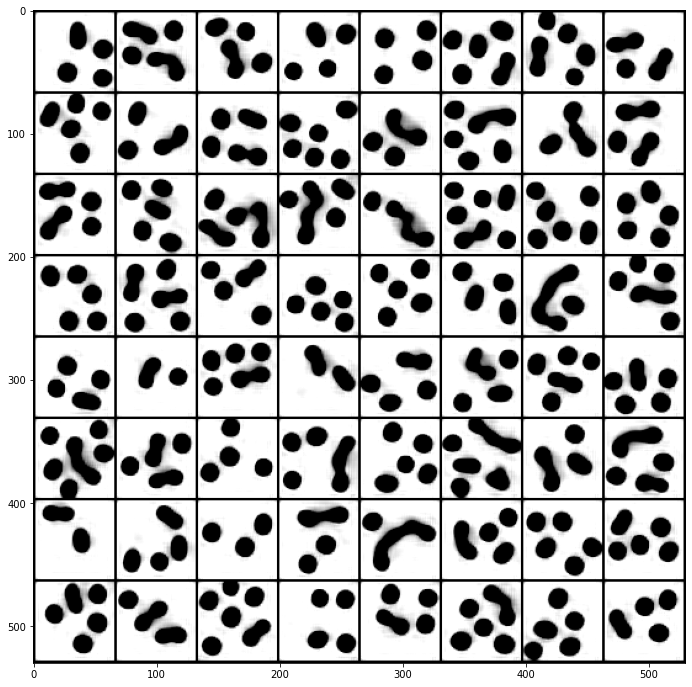

In [23]:
n_steps = 40
x = torch.rand(64, 1, N, N).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='gray')
plt.show()